# Fine-tuning gemma2-2b for structured data extraction

**Use case**:

The goal is to extract structured output data from a text in a structured way (JSON format is the most common).

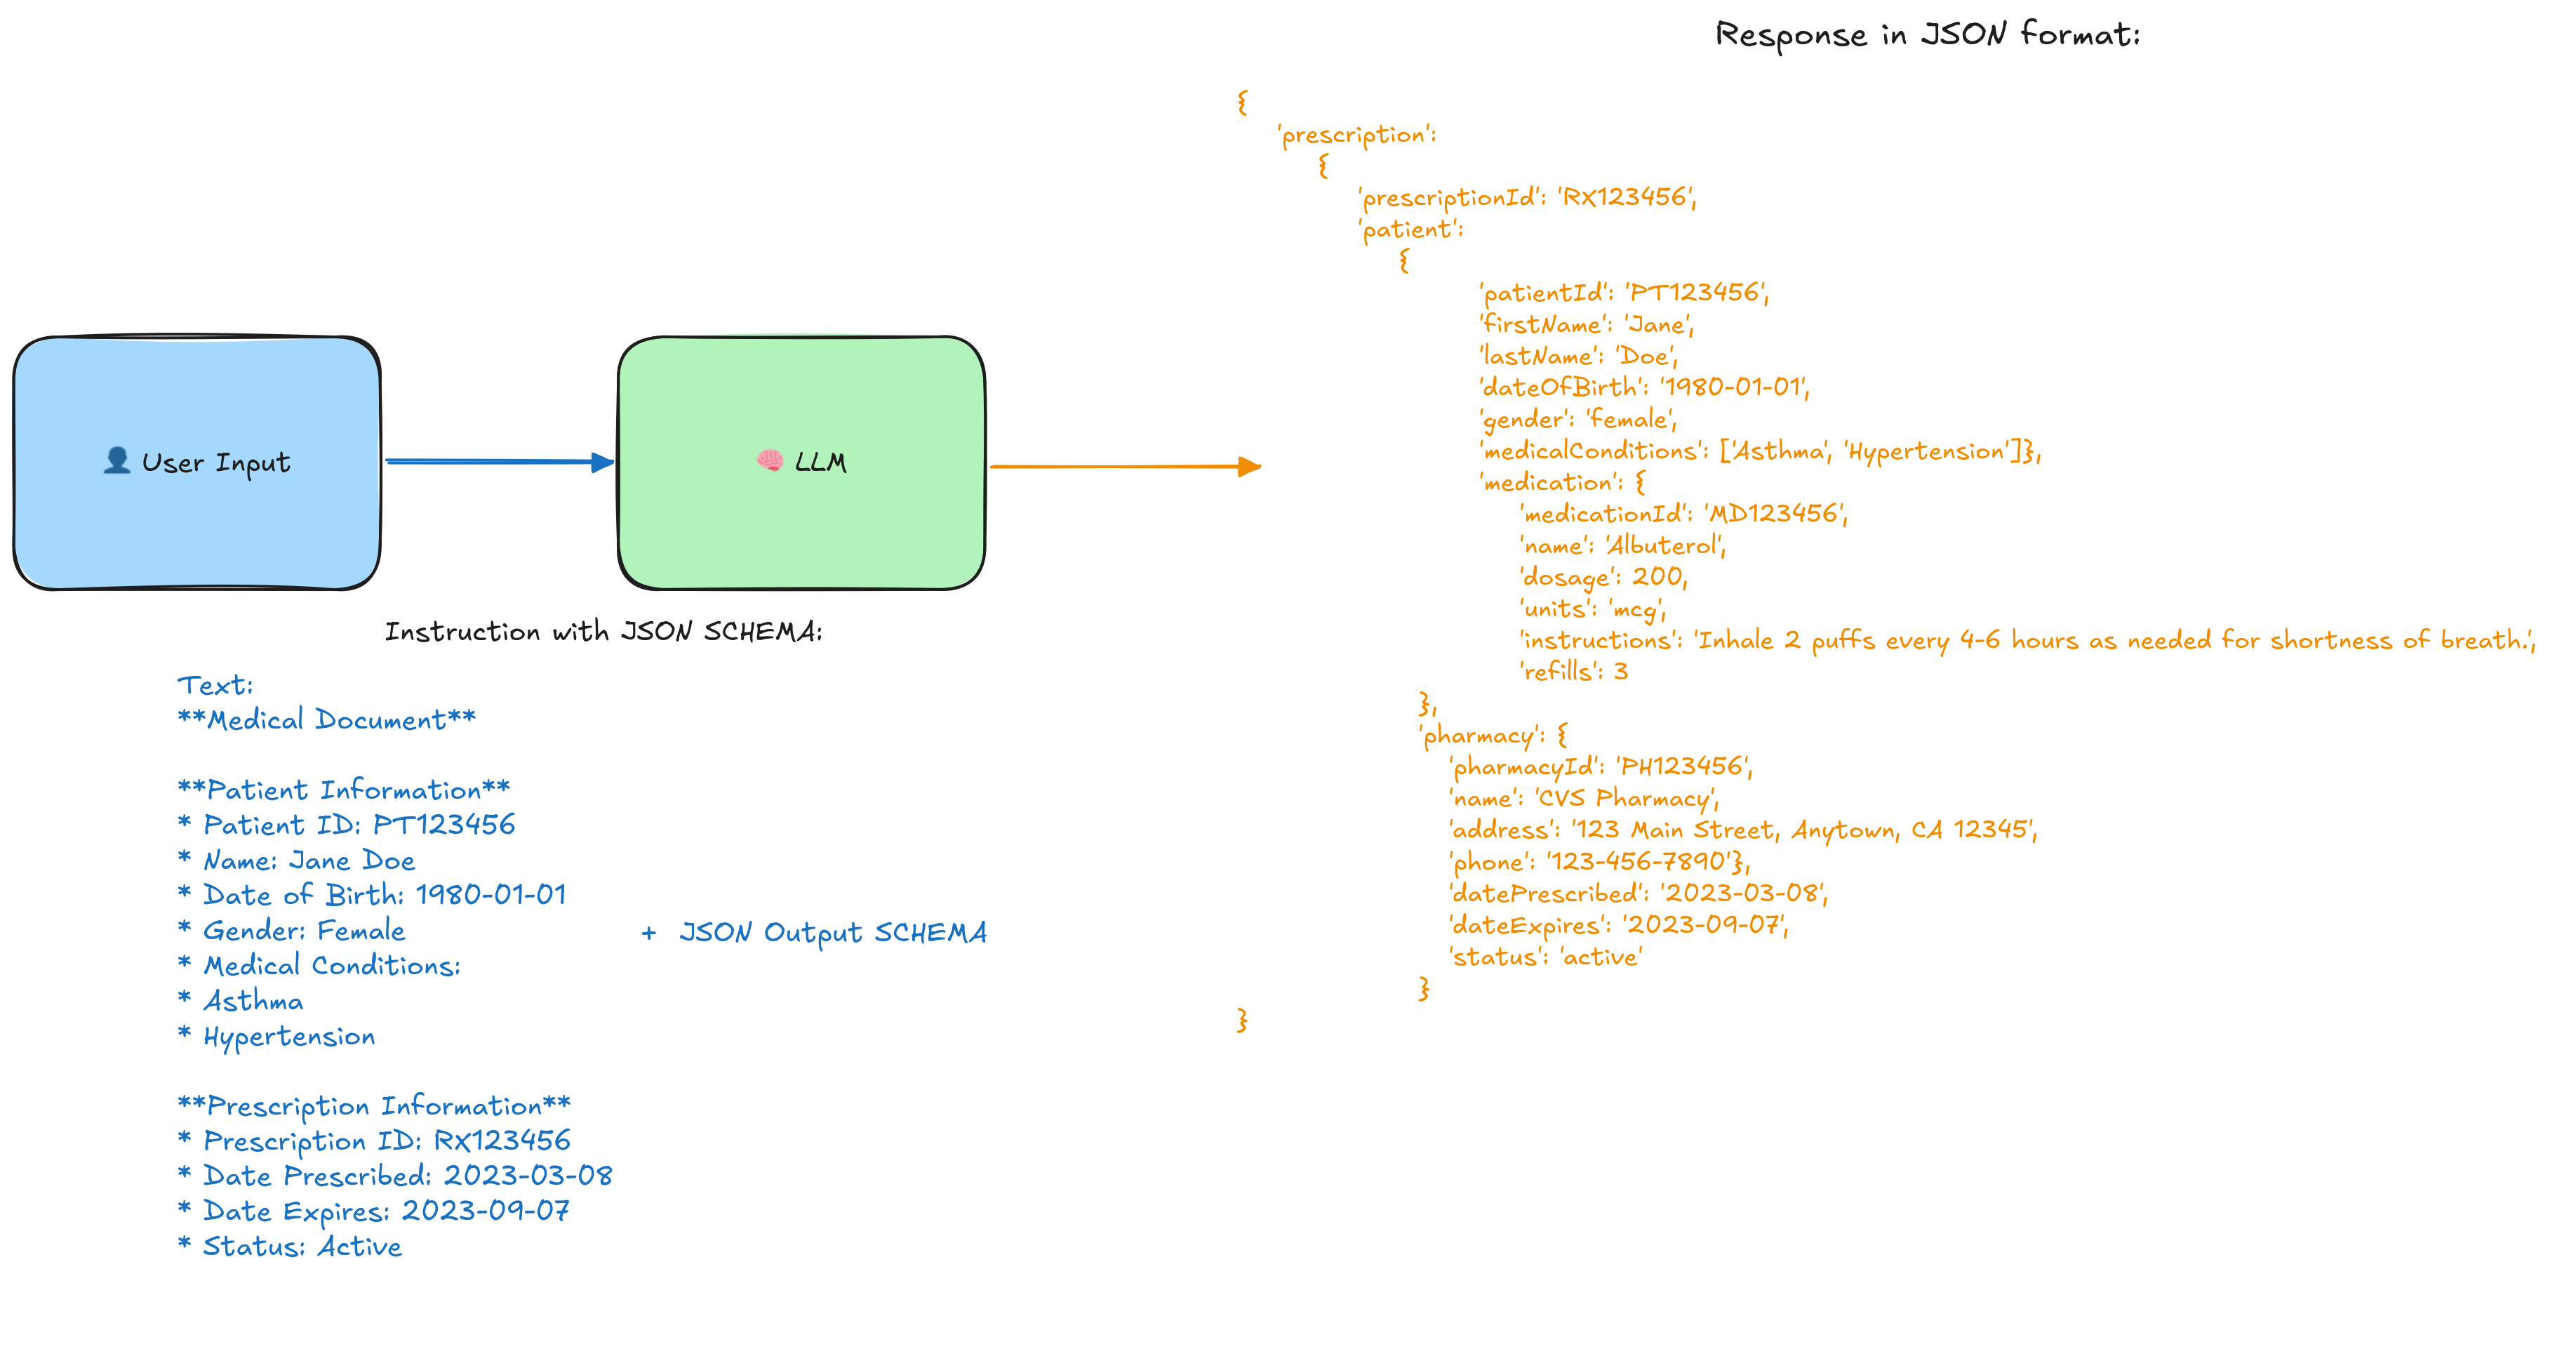



I decided to use gemma2-2b because it is a distilled model with great performance on the various benchmarks.

As we are on limited hardware, we can use the 2B parameter version of the model, which allows for speed of fine tuning.

In [5]:
%%capture
# Installs Unsloth, Xformers (Flash Attention) and all other packages!
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps "xformers<0.0.27" "trl<0.9.0" peft accelerate bitsandbytes

import torch

if torch.cuda.get_device_capability()[0] >= 8:
    !pip install --no-deps packaging ninja einops "flash-attn>=2.6.3"

In [6]:
# Known issue with Gemma-2 and cache issue
torch._dynamo.config.accumulated_cache_size_limit = 2048

In [7]:
from google.colab import userdata

HF_TOKEN_READ = userdata.get("HF_TOKEN_READ")
HF_TOKEN_WRITE = userdata.get("HF_TOKEN_WRITE")

# Gemma-2-2b fine-tuning with unsloth

Unsloth is a framework used to simplify the process of fine-tuning a model by reducing the amount of boilerplate.

In [3]:
from unsloth import FastLanguageModel

import torch

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="google/gemma-2-2b-it",
    max_seq_length=2048,
    dtype=torch.float16,  # For Tesla T4
    load_in_4bit=False,
    token=HF_TOKEN_READ,
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
==((====))==  Unsloth 2024.8: Fast Gemma2 patching. Transformers = 4.44.0.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.1+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.26.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.23G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

We are now adding LoRA adapters so that we only need to update a small number of parameters (<10%) due to the limited computing power available.

In [4]:
model = FastLanguageModel.get_peft_model(
    model,
    r=16,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
    ],
    lora_alpha=16,
    lora_dropout=0,
    bias="none",
    use_gradient_checkpointing="unsloth",
    random_state=42,
    use_rslora=True,  # Rank stabilized LoRA seems to outperform LoRa (according to Rank-Stabilized LoRA paper)
)

Not an error, but Unsloth cannot patch MLP layers with our manual autograd engine since either LoRA adapters
are not enabled or a bias term (like in Qwen) is used.
Unsloth 2024.8 patched 26 layers with 26 QKV layers, 26 O layers and 0 MLP layers.


### Preparing the dataset
We will now use the json_data_extraction dataset from paraloq.ai.

The json_data_extraction is a dataset with 484 samples.

The dataset consists of text, a json output schema and a json output ground truth.

The pre-processing of the dataset is as follows:
- Format the JSON prompt consisting of:
    1. The command
    2. Text input
    3. A JSON Schema
    4. The format of the input

In [5]:
from datasets import load_dataset

json_prompt = """Below is a text paired with input that provides further context. Write JSON output that matches the schema to extract information.

### Input:
{}

### Schema:
{}

### Response:
{}"""


def formatting_prompts_func(examples):
    inputs = examples["text"]
    schemas = examples["schema"]
    outputs = examples["item"]
    texts = []

    for input, schema, output in zip(inputs, schemas, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = json_prompt.format(input, schema, output) + tokenizer.eos_token
        texts.append(text)
    return {
        "text": texts,
    }

dataset = load_dataset("paraloq/json_data_extraction", split="train[:60%]")
dataset = dataset.map(
    formatting_prompts_func,
    batched=True,
)

Generating train split:   0%|          | 0/484 [00:00<?, ? examples/s]

Map:   0%|          | 0/290 [00:00<?, ? examples/s]

<
### Train the model

Unsloth supports the Huggingface TRL's `SFTTrainer`!

We use supervised fine-tuning with our ground truth with a LoRa fine-tuning due to the limited memory on the collab T4.

In [6]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=dataset,
    dataset_text_field="text",
    max_seq_length=2048,
    dataset_num_proc=2,
    packing=True,
    args=TrainingArguments(
        per_device_train_batch_size=2,
        gradient_accumulation_steps=4,
        warmup_steps=5,
        max_steps=60,
        learning_rate=2e-4,
        fp16=not is_bfloat16_supported(),
        bf16=is_bfloat16_supported(),
        logging_steps=1,
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="linear",
        seed=42,
        output_dir="outputs",
    ),
)

Generating train split: 0 examples [00:00, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs


## Reserved GPU memory

In [7]:
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.748 GB.
5.594 GB of memory reserved.


In [8]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 191 | Num Epochs = 3
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 60
 "-____-"     Number of trainable parameters = 6,389,760


Step,Training Loss
1,0.769400
2,0.730800
3,0.806400
4,0.525800
5,0.665000
6,0.582900
7,0.572300
8,0.666000
9,0.536900
10,0.557000


In [9]:
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

1489.5908 seconds used for training.
24.83 minutes used for training.
Peak reserved memory = 12.311 GB.
Peak reserved memory for training = 6.717 GB.
Peak reserved memory % of max memory = 83.476 %.
Peak reserved memory for training % of max memory = 45.545 %.


### Inference

Now let's run the model! On an example of the training data.

Using an openapi json format schema.

In [10]:
schema = """
{
    '$schema': 'http://json-schema.org/draft-07/schema#',
    '$defs': {
        'Patient': {
            'type': 'object',
            'properties': {
                'patientId': {
                    'type': 'string',
                    'minLength': 1,
                    'maxLength': 255
                },
                'firstName': {
                    'type': 'string',
                    'minLength': 1,
                    'maxLength': 255
                },
                'lastName': {
                    'type': 'string',
                    'minLength': 1,
                    'maxLength': 255
                },
                'dateOfBirth': {
                    'type': 'string',
                    'format': 'date'
                },
                'gender': {
                    'type': 'string',
                    'enum': [
                        'male',
                        'female',
                        'other'
                    ]
                },
                'medicalConditions': {
                    'type': 'array',
                    'items': {
                        'type': 'string',
                        'minLength': 1,
                        'maxLength': 255
                    },
                    'minItems': 0,
                    'uniqueItems': true
                }
            },
            'required': [
                'patientId',
                'firstName',
                'lastName',
                'dateOfBirth',
                'gender'
            ]
        },
        'Medication': {
            'type': 'object',
            'properties': {
                'medicationId': {
                    'type': 'string',
                    'minLength': 1,
                    'maxLength': 255
                },
                'name': {
                    'type': 'string',
                    'minLength': 1,
                    'maxLength': 255
                },
                'dosage': {
                    'type': 'number',
                    'minimum': 0
                },
                'units': {
                    'type': 'string',
                    'minLength': 1,
                    'maxLength': 255
                },
                'instructions': {
                    'type': 'string',
                    'minLength': 1,
                    'maxLength': 255
                },
                'refills': {
                    'type': 'number',
                    'minimum': 0
                }
            },
            'required': [
                'medicationId',
                'name',
                'dosage',
                'units',
                'instructions',
                'refills'
            ]
        },
        'Pharmacy': {
            'type': 'object',
            'properties': {
                'pharmacyId': {
                    'type': 'string',
                    'minLength': 1,
                    'maxLength': 255
                },
                'name': {
                    'type': 'string',
                    'minLength': 1,
                    'maxLength': 255
                },
                'address': {
                    'type': 'string',
                    'minLength': 1,
                    'maxLength': 255
                },
                'phone': {
                    'type': 'string',
                    'minLength': 1,
                    'maxLength': 255
                }
            },
            'required': [
                'pharmacyId',
                'name',
                'address'
            ]
        },
        'Prescription': {
            'type': 'object',
            'properties': {
                'prescriptionId': {
                    'type': 'string',
                    'minLength': 1,
                    'maxLength': 255
                },
                'patient': {
                    '$ref': '#/$defs/Patient'
                },
                'medication': {
                    '$ref': '#/$defs/Medication'
                },
                'pharmacy': {
                    '$ref': '#/$defs/Pharmacy'
                },
                'datePrescribed': {
                    'type': 'string',
                    'format': 'date'
                },
                'dateExpires': {
                    'type': 'string',
                    'format': 'date'
                },
                'status': {
                    'type': 'string',
                    'enum': [
                        'active',
                        'inactive',
                        'expired'
                    ]
                }
            },
            'required': [
                'prescriptionId',
                'patient',
                'medication',
                'pharmacy',
                'datePrescribed'
            ]
        }
    },
    'type': 'object',
    'properties': {
        'prescription': {
            '$ref': '#/$defs/Prescription'
        }
    },
    'required': [
        'prescription'
    ]
}
"""

Let's use the json_prompt used for supervised fine-tuning.

In [11]:
prompt = json_prompt.format(
    "**Medical Document** **Patient Information** * Patient ID: PT123456 * Name: Jane Doe * Date of Birth: 1980-01-01 * Gender: Female * Medical Conditions: * Asthma * Hypertension **Prescription Information** * Prescription ID: RX123456 * Date Prescribed: 2023-03-08 * Date Expires: 2023-09-07 * Status: Active **Medication Information** * Medication ID: MD123456 * Name: Albuterol * Dosage: 200 mcg * Units: mcg * Instructions: Inhale 2 puffs every 4-6 hours as needed for shortness of breath. * Refills: 3 **Pharmacy Information** * Pharmacy ID: PH123456 * Name: CVS Pharmacy * Address: 123 Main Street, Anytown, CA 12345 * Phone: (123) 456-7890 **Additional Information** * The patient has been using Albuterol for the past 5 years to manage her asthma. * The patient has been advised to use a spacer device with the Albuterol inhaler to improve the delivery of the medication to the lungs. * The patient should avoid using Albuterol more than 4 times per day. * The patient should contact her doctor if her asthma symptoms worsen or if she experiences any side effects from the medication. **Instructions for the Patient** * Take Albuterol exactly as prescribed by your doctor. * Do not take more than the prescribed dosage. * Use a spacer device with the Albuterol inhaler. * Avoid using Albuterol more than 4 times per day. * Contact your doctor if your asthma symptoms worsen or if you experience any side effects from the medication. **Signature** [Doctor's Name] [Date]",
    schema,
    "",
)

The FastLanguageModel interface is similar to the Hugging Face Transformer library interface, but enables FlashAttention by default and improves inference on the model supported by unsloth.

In [18]:
FastLanguageModel.for_inference(model)

inputs = tokenizer([prompt], return_tensors="pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens=1024, use_cache=True)
result = tokenizer.batch_decode(outputs)[0][len(prompt) + 5 : -5]

Let's parse the json output.

In [19]:
import json

json.loads(result)

{'prescription': {'prescriptionId': 'RX123456',
  'patient': {'patientId': 'PT123456',
   'firstName': 'Jane',
   'lastName': 'Doe',
   'dateOfBirth': '1980-01-01',
   'gender': 'female',
   'medicalConditions': ['Asthma', 'Hypertension']},
  'medication': {'medicationId': 'MD123456',
   'name': 'Albuterol',
   'dosage': 200,
   'units': 'mcg',
   'instructions': 'Inhale 2 puffs every 4-6 hours as needed for shortness of breath.',
   'refills': 3},
  'pharmacy': {'pharmacyId': 'PH123456',
   'name': 'CVS Pharmacy',
   'address': '123 Main Street, Anytown, CA 12345',
   'phone': '(123) 456-7890'},
  'datePrescribed': '2023-03-08',
  'dateExpires': '2023-09-07',
  'status': 'active'}}

### Saving, loading finetuned models

In [1]:
USERNAME = "bastienp"

In [21]:
model.push_to_hub(f"{USERNAME}/Gemma-2-2B-it-JSON-data-extration", token=HF_TOKEN_WRITE)
tokenizer.push_to_hub(
    f"{USERNAME}/Gemma-2-2B-it-JSON-data-extration", token=HF_TOKEN_WRITE
)

README.md:   0%|          | 0.00/565 [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/25.6M [00:00<?, ?B/s]

Saved model to https://huggingface.co/bastienp/Gemma-2-2B-it-JSON-data-extration


  0%|          | 0/2 [00:00<?, ?it/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

### Loading the model from the hub

In [4]:
from peft import AutoPeftModelForCausalLM
from transformers import AutoTokenizer

model = AutoPeftModelForCausalLM.from_pretrained(
    f"{USERNAME}/Gemma-2-2B-it-JSON-data-extration"
)
tokenizer = AutoTokenizer.from_pretrained(
    f"{USERNAME}/Gemma-2-2B-it-JSON-data-extration"
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/25.6M [00:00<?, ?B/s]

### Quantization: GGUF / llama.cpp Conversion
Let's now save the model to GGUF format to be used with llama.cpp or other ggml based runtime.

* `q4_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q4_K.
* `q5_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q5_K.

I decided to go with the gguf approach as it well integrated with most on the runtime framework.

The GGUF approach is based on the K-quants algorithm dividing the the weight and attention tensor into superblock.

Good explanation can be found [here](https://www.reddit.com/r/LocalLLaMA/comments/1ba55rj/overview_of_gguf_quantization_methods/).

The model is quantized in different version with linear quantization.

In [8]:
import torch
from unsloth import FastLanguageModel

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name=f"{USERNAME}/Gemma-2-2B-it-JSON-data-extration",
    max_seq_length=2048,
    dtype=torch.float16,
    load_in_4bit=False,
    token=HF_TOKEN_READ,
)

model.push_to_hub_gguf(
    f"{USERNAME}/Gemma-2-2B-it-JSON-data-extration",
    tokenizer,
    quantization_method=[
        "q4_k_m",
        "q8_0",
        "q5_k_m",
    ],
    token=HF_TOKEN_WRITE,
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
==((====))==  Unsloth 2024.8: Fast Gemma2 patching. Transformers = 4.44.0.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.1+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.26.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.23G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/25.6M [00:00<?, ?B/s]

Not an error, but Unsloth cannot patch MLP layers with our manual autograd engine since either LoRA adapters
are not enabled or a bias term (like in Qwen) is used.
Unsloth 2024.8 patched 26 layers with 26 QKV layers, 26 O layers and 0 MLP layers.
Unsloth: ##### The current model auto adds a BOS token.
Unsloth: ##### Your chat template has a BOS token. We shall remove it temporarily.
Unsloth: You have 1 CPUs. Using `safe_serialization` is 10x slower.
We shall switch to Pytorch saving, which will take 3 minutes and not 30 minutes.
To force `safe_serialization`, set it to `None` instead.
Unsloth: Kaggle/Colab has limited disk space. We need to delete the downloaded
model which will save 4-16GB of disk space, allowing you to save on Kaggle/Colab.
Unsloth: Will remove a cached repo with size 5.2G


Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 6.96 out of 12.67 RAM for saving.


100%|██████████| 26/26 [00:01<00:00, 21.37it/s]


Unsloth: Saving tokenizer... Done.
Unsloth: Saving model... This might take 5 minutes for Llama-7b...
Unsloth: Saving bastienp/Gemma-2-2B-it-JSON-data-extration/pytorch_model-00001-of-00002.bin...
Unsloth: Saving bastienp/Gemma-2-2B-it-JSON-data-extration/pytorch_model-00002-of-00002.bin...
Done.


Unsloth: Converting gemma2 model. Can use fast conversion = False.


==((====))==  Unsloth: Conversion from QLoRA to GGUF information
   \\   /|    [0] Installing llama.cpp will take 3 minutes.
O^O/ \_/ \    [1] Converting HF to GGUF 16bits will take 3 minutes.
\        /    [2] Converting GGUF 16bits to ['q4_k_m', 'q8_0', 'q5_k_m'] will take 10 minutes each.
 "-____-"     In total, you will have to wait at least 16 minutes.

Unsloth: [0] Installing llama.cpp. This will take 3 minutes...
Unsloth: [1] Converting model at bastienp/Gemma-2-2B-it-JSON-data-extration into f16 GGUF format.
The output location will be ./bastienp/Gemma-2-2B-it-JSON-data-extration/unsloth.F16.gguf
This will take 3 minutes...
INFO:hf-to-gguf:Loading model: Gemma-2-2B-it-JSON-data-extration
INFO:gguf.gguf_writer:gguf: This GGUF file is for Little Endian only
INFO:hf-to-gguf:Exporting model...
INFO:hf-to-gguf:gguf: loading model weight map from 'pytorch_model.bin.index.json'
INFO:hf-to-gguf:gguf: loading model part 'pytorch_model-00001-of-00002.bin'
INFO:hf-to-gguf:token_embd.weigh

  0%|          | 0/1 [00:00<?, ?it/s]

unsloth.F16.gguf:   0%|          | 0.00/5.24G [00:00<?, ?B/s]

Saved GGUF to https://huggingface.co/bastienp/Gemma-2-2B-it-JSON-data-extration
Unsloth: Uploading GGUF to Huggingface Hub...


  0%|          | 0/1 [00:00<?, ?it/s]

unsloth.Q4_K_M.gguf:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Saved GGUF to https://huggingface.co/bastienp/Gemma-2-2B-it-JSON-data-extration
Unsloth: Uploading GGUF to Huggingface Hub...


  0%|          | 0/1 [00:00<?, ?it/s]

unsloth.Q8_0.gguf:   0%|          | 0.00/2.78G [00:00<?, ?B/s]

Saved GGUF to https://huggingface.co/bastienp/Gemma-2-2B-it-JSON-data-extration
Unsloth: Uploading GGUF to Huggingface Hub...


  0%|          | 0/1 [00:00<?, ?it/s]

unsloth.Q5_K_M.gguf:   0%|          | 0.00/1.92G [00:00<?, ?B/s]

Unsloth: ##### The current model auto adds a BOS token.
Unsloth: ##### We removed it in GGUF's chat template for you.


Saved GGUF to https://huggingface.co/bastienp/Gemma-2-2B-it-JSON-data-extration


The different quantization change the model from 5.24GB up to 1.71GB for Q4_k_m quantization.